<a href="https://colab.research.google.com/github/nathandclark/PS408_DarkMatter/blob/main/Galaxy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Galaxy

This code is adapted from Carrol & Ostlie's (2017) an Introduction to Modern Astrophysics, Appendix M. The code simulates the interations of 2 galaxies. You will need to adapt the code to model 2 of your assigned galaxies, including and not including dark matter.

Created:      Tue/11/14/17 (Cal Poly)
Last update:  Fri/Mar/20/20 (Kamp)
Author:       Jose Flores Velazquez

In [ ]:
import numpy as np
import glob
import sys
import os
import copy
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#...Set up font size:
fontsize = 14

### UNITS OF CODE

These units make it possible for gravitational constant to equal 1 (G=1).
    
* 1 unit of Mass     = 2x10^(10) Solar Masses
* 1 unit of Distance = 500 pc
* 1 unit of Time     = 1.2 million years
* 1 unit of Velocity = 400 km/s

In [ ]:
def acceleration_stars(spiral_coordinates, neighbor_coordinates, star_coordinates_x, star_coordinates_y, star_coordinates_z, params, t):

    #---- Unpacking Variables
    X1 = spiral_coordinates[0]
    Y1 = spiral_coordinates[1]
    Z1 = spiral_coordinates[2]

    X2 = neighbor_coordinates[0]
    Y2 = neighbor_coordinates[1]
    Z2 = neighbor_coordinates[2]

    x = star_coordinates_x
    y = star_coordinates_y
    z = star_coordinates_z

    G  = params[0]
    sf = params[1]
    M1 = params[2]
    M2 = params[3]

    #---- Determining Radial Distance (Denominator of Acceleration)
    r1 = np.sqrt((X1-x)**2 + (Y1-y)**2 + (Z1-z)**2 + sf**2)
    r2 = np.sqrt((X2-x)**2 + (Y2-y)**2 + (Z2-z)**2 + sf**2)

    #---- Acceleration for each star
    acceleration_x = (((G*M1)/(r1**3))*(X1-x)) + (((G*M2)/(r2**3))*(X2-x))
    acceleration_y = (((G*M1)/(r1**3))*(Y1-y)) + (((G*M2)/(r2**3))*(Y2-y))
    acceleration_z = (((G*M1)/(r1**3))*(Z1-z)) + (((G*M2)/(r2**3))*(Z2-z))


    return acceleration_x, acceleration_y, acceleration_z, r1, r2

In [ ]:
def acceleration_nuclei(spiral_coordinates, neighbor_coordinates, params, t):

    #---- Unpacking Variables
    X1 = spiral_coordinates[0]
    Y1 = spiral_coordinates[1]
    Z1 = spiral_coordinates[2]

    X2 = neighbor_coordinates[0]
    Y2 = neighbor_coordinates[1]
    Z2 = neighbor_coordinates[2]

    G  = params[0]
    sf = params[1]
    M1 = params[2]
    M2 = params[3]

    #---- Determining Radial Distance (Denominator of Acceleration)
    s = np.sqrt((X1-X2)**2 + (Y1-Y2)**2 + (Z1-Z2)**2 + sf**2)

    #---- Acceleration for each nuclei
    Acceleration_1x = ((G*M2)/(s**3)) * (X2-X1)
    Acceleration_1y = ((G*M2)/(s**3)) * (Y2-Y1)
    Acceleration_1z = ((G*M2)/(s**3)) * (Z2-Z1)

    Acceleration_2x = ((G*M1)/(s**3)) * (X1-X2)
    Acceleration_2y = ((G*M1)/(s**3)) * (Y1-Y2)
    Acceleration_2z = ((G*M1)/(s**3)) * (Z1-Z2)

    Acceleration_Spiral      = np.array([Acceleration_1x, Acceleration_1y, Acceleration_1z])
    Acceleration_Neighboring = np.array([Acceleration_2x, Acceleration_2y, Acceleration_2z])

    return Acceleration_Spiral, Acceleration_Neighboring, s

In [ ]:
#---- Galaxy Parameters
initial_diameter_spiral  = 52.0
initial_radius_spiral    = initial_diameter_spiral / 2.0
Number_rings_stars       = 10

#---- Mass of galaxies
Spiral_Galaxy_Mass      = 5.0
Neighboring_Galaxy_Mass = (1.0/4.0) * Spiral_Galaxy_Mass

#---- Initial Positions of Galaxies
Spiral_Galaxy_x0 = 0.0
Spiral_Galaxy_y0 = 0.0
Spiral_Galaxy_z0 = 0.0

Neighboring_Galaxy_x0 = -30.0
Neighboring_Galaxy_y0 = -30.0
Neighboring_Galaxy_z0 = 0.0
Pos_Neigh = np.sqrt(Neighboring_Galaxy_x0**2 + Neighboring_Galaxy_y0**2 + Neighboring_Galaxy_z0**2)

#---- Initial Velocities of Galaxies
Spiral_Galaxy_v_x0 = 0.0
Spiral_Galaxy_v_y0 = 0.0
Spiral_Galaxy_v_z0 = 0.0

Neighboring_Galaxy_v_x0 = 0.0
Neighboring_Galaxy_v_y0 = 0.34
Neighboring_Galaxy_v_z0 = 0.34

#---- Softening Factor, Gravitational Constant, Degree of Freedom
#sf  = 3.5
#sf  = 2.01
sf = 2.016
#sf = 1.0
G   = 1.0
dof = 3

In [ ]:
#---- Time Step
dt        = 1.0
time_step = 540
time      = np.arange(0,time_step+1,dt)
half_dt    = 0.5 * dt
half_dt_sq = 0.5 * (dt*dt)

#---- Parameters
params = np.array([G, sf, Spiral_Galaxy_Mass, Neighboring_Galaxy_Mass])

#---- Initial Positions of Stars in Spiral Galaxy

#...A ring is located every 2.6 distance appart
radius_each_ring = np.arange(0, initial_radius_spiral+(initial_radius_spiral/Number_rings_stars), initial_radius_spiral/Number_rings_stars)
radius_each_ring = radius_each_ring[1::]

#...Degrees of each star in every quadrant
degree_each_star_Q1 = np.arange(0, 90.0, 180.0/25.0)
degree_each_star_Q4 = (degree_each_star_Q1[1::] * -1.04)
degree_each_star_Q2 = degree_each_star_Q1 + 90
degree_each_star_Q3 = degree_each_star_Q4 + 270
degree_each_star_Q4 = degree_each_star_Q4 + 360

#...Connecting degrees of stars to form circle
semi_circle_top    = np.concatenate((degree_each_star_Q1,degree_each_star_Q2))
semi_circle_bottom = np.concatenate((degree_each_star_Q3, degree_each_star_Q4))
degree_circle      = sorted(np.concatenate((semi_circle_top, semi_circle_bottom)))

#...Emtpy data containers to store positions of stars in each ring
x_pos = []
y_pos = []

#...Updating empty containers with x and y positions of stars
for j in np.arange(len(radius_each_ring)):
    for i in np.arange(len(degree_circle)):
         x_pos.append(radius_each_ring[j]*np.cos(degree_circle[i]*np.pi/180.0))
         y_pos.append(radius_each_ring[j]*np.sin(degree_circle[i]*np.pi/180.0))

In [ ]:
#...Total Star
Number_stars                  = len(x_pos)
Initial_Star_Coordinates      = np.zeros([Number_stars, dof])
Initial_Star_Coordinates[:,0] = x_pos
Initial_Star_Coordinates[:,1] = y_pos

#---- Star Data
Star_Coordinates_x = np.zeros([time_step,Number_stars])
Star_Coordinates_y = np.zeros([time_step,Number_stars])
Star_Coordinates_z = np.zeros([time_step,Number_stars])

Star_Velocities_x = np.zeros([time_step,Number_stars])
Star_Velocities_y = np.zeros([time_step,Number_stars])
Star_Velocities_z = np.zeros([time_step,Number_stars])

Star_Accelerations_x = np.zeros([time_step,Number_stars])
Star_Accelerations_y = np.zeros([time_step,Number_stars])
Star_Accelerations_z = np.zeros([time_step,Number_stars])

#---- Initializing Star Data
Star_Coordinates_x[0] = Initial_Star_Coordinates[:,0]
Star_Coordinates_y[0] = Initial_Star_Coordinates[:,1]
Star_Coordinates_z[0] = Initial_Star_Coordinates[:,2]

#---- Establishing Data Arrays
Spiral_Galaxy_Coordinates = np.zeros([time_step,dof])
Neighb_Galaxy_Coordinates = np.zeros([time_step,dof])

Spiral_Galaxy_Velocities  = np.zeros([time_step,dof])
Neighb_Galaxy_Velocities  = np.zeros([time_step,dof])

Spiral_Galaxy_Accelerations = np.zeros([time_step,dof])
Neighb_Galaxy_Accelerations = np.zeros([time_step,dof])

#---- Initializing Data Arrays
Spiral_Galaxy_Coordinates[0]  = Spiral_Galaxy_x0, Spiral_Galaxy_y0, Spiral_Galaxy_z0
Spiral_Galaxy_Velocities[0]   = Spiral_Galaxy_v_x0, Spiral_Galaxy_v_y0, Spiral_Galaxy_v_z0

Neighb_Galaxy_Coordinates[0]  = Neighboring_Galaxy_x0, Neighboring_Galaxy_y0, Neighboring_Galaxy_z0
Neighb_Galaxy_Velocities[0]   = Neighboring_Galaxy_v_x0, Neighboring_Galaxy_v_y0, Neighboring_Galaxy_v_z0


#...Initial Acceleration of Nuclei
spiral_acc, neighb_acc, s = acceleration_nuclei(Spiral_Galaxy_Coordinates[0], Neighb_Galaxy_Coordinates[0], params,0)

In [ ]:
#---- Star Acceleration
for i in np.arange(len(Star_Coordinates_z)):
    Star_Accelerations_x[i], Star_Accelerations_y[i], Star_Accelerations_z[i], r1, r2 = acceleration_stars(Spiral_Galaxy_Coordinates[0], Neighb_Galaxy_Coordinates[0], Star_Coordinates_x[i], Star_Coordinates_y[i], Star_Coordinates_z[i], params, 0)

#---- Velocity Verlet Method For Calculating Positions, Speeds, & Accelerations

#...Calculations for Center Buldges Positions, Speeds, & Accelerations
for t in range(1,time_step):

    #---- Updating Coordinates
    Spiral_Galaxy_Coordinates[t] = Spiral_Galaxy_Coordinates[t-1] + Spiral_Galaxy_Velocities[t-1]*dt + half_dt_sq * Spiral_Galaxy_Accelerations[t-1]
    Neighb_Galaxy_Coordinates[t] = Neighb_Galaxy_Coordinates[t-1] + Neighb_Galaxy_Velocities[t-1]*dt + half_dt_sq * Neighb_Galaxy_Accelerations[t-1]

    #---- Current Acceleration
    acc1, acc2, s = acceleration_nuclei(Spiral_Galaxy_Coordinates[t], Neighb_Galaxy_Coordinates[t], params, time[t])
#    print "s", acc1, acc2
    #---- Updating Velocities
    Spiral_Galaxy_Velocities[t] = Spiral_Galaxy_Velocities[t-1] + half_dt * (acc1 + Spiral_Galaxy_Accelerations[t-1])
    Neighb_Galaxy_Velocities[t] = Neighb_Galaxy_Velocities[t-1] + half_dt * (acc2 + Neighb_Galaxy_Accelerations[t-1])

    Spiral_Galaxy_Accelerations[t] = acc1
    Neighb_Galaxy_Accelerations[t] = acc2

#...Calculations for Star's Positions, Speeds, & Accelerations
for t in range(1,time_step):

    for j in range(Number_stars):

        #---- Updating Coordinates
        Star_Coordinates_x[t][j] = Star_Coordinates_x[t-1][j] + Star_Velocities_x[t-1][j]*dt + half_dt_sq * Star_Accelerations_x[t-1][j]
        Star_Coordinates_y[t][j] = Star_Coordinates_y[t-1][j] + Star_Velocities_y[t-1][j]*dt + half_dt_sq * Star_Accelerations_y[t-1][j]
        Star_Coordinates_z[t][j] = Star_Coordinates_z[t-1][j] + Star_Velocities_z[t-1][j]*dt + half_dt_sq * Star_Accelerations_z[t-1][j]

        #---- Current Acceleration
        acc_x, acc_y, acc_z, r1, r2 = acceleration_stars(Spiral_Galaxy_Coordinates[t], Neighb_Galaxy_Coordinates[t], Star_Coordinates_x[t][j], Star_Coordinates_y[t][j], Star_Coordinates_z[t][j], params, time[t])
#        print "r's", acc_x, acc_y, acc_z

        #---- Updating Velocities
        Star_Velocities_x[t][j] = Star_Velocities_x[t-1][j] + half_dt * (acc_x + Star_Accelerations_x[t-1][j])
        Star_Velocities_y[t][j] = Star_Velocities_y[t-1][j] + half_dt * (acc_y + Star_Accelerations_y[t-1][j])
        Star_Velocities_z[t][j] = Star_Velocities_z[t-1][j] + half_dt * (acc_z + Star_Accelerations_z[t-1][j])

        Star_Accelerations_x[t][j] = acc_x
        Star_Accelerations_y[t][j] = acc_y
        Star_Accelerations_z[t][j] = acc_z

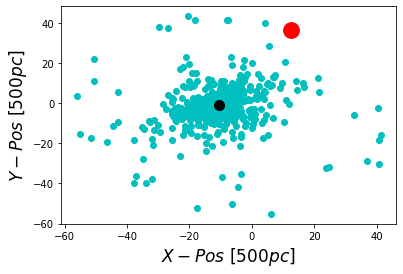

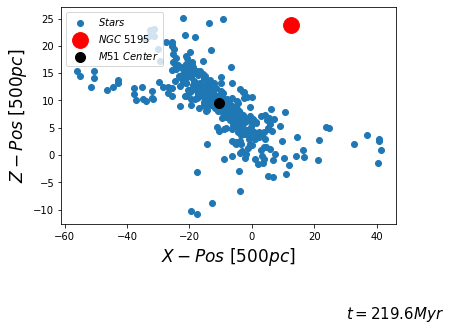

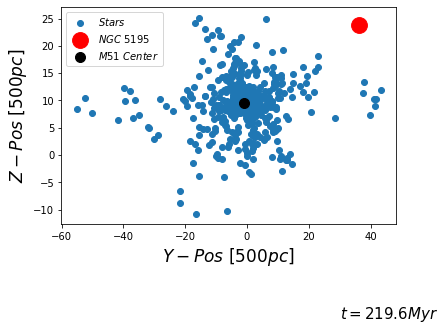

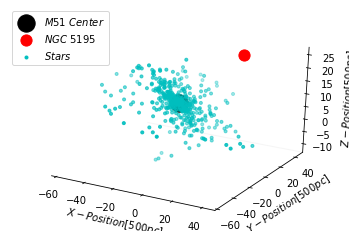

In [ ]:
#---- Time of Snapshot you want to visualize
time_analyzing = 183

#---- 2D Top View Projections

#... X vs Y Slice
plt.scatter(Star_Coordinates_x[time_analyzing],Star_Coordinates_y[time_analyzing], label = '$Stars$', c='c')
plt.scatter(Neighb_Galaxy_Coordinates[time_analyzing][0],Neighb_Galaxy_Coordinates[time_analyzing][1], label='$NGC$ $5195$', c='r', s=250)
plt.scatter(Spiral_Galaxy_Coordinates[time_analyzing][0],Spiral_Galaxy_Coordinates[time_analyzing][1], label = '$M51$ $Center$',      c='k', s=100 )
plt.xlabel('$X-Pos$ [$500pc$]', fontsize=17)
plt.ylabel('$Y-Pos$ [$500pc$]', fontsize=17)
#plt.ylim(-40,65)
#plt.xlim(-80,70)
#plt.text(30,-30, '$t=$' + str(time_analyzing*1.2) + '$Myr$', fontsize=15)
#plt.legend(loc='upper left', scatterpoints = 1)
plt.show()

#... X vs Z Slice
plt.scatter(Star_Coordinates_x[time_analyzing],Star_Coordinates_z[time_analyzing], label = '$Stars$')
plt.scatter(Neighb_Galaxy_Coordinates[time_analyzing][0],Neighb_Galaxy_Coordinates[time_analyzing][2], label='$NGC$ $5195$', c='r', s=250)
plt.scatter(Spiral_Galaxy_Coordinates[time_analyzing][0],Spiral_Galaxy_Coordinates[time_analyzing][2], label = '$M51$ $Center$',      c='k', s=100 )
plt.xlabel('$X-Pos$ [$500pc$]', fontsize=17)
plt.ylabel('$Z-Pos$ [$500pc$]', fontsize=17)
#plt.ylim(-40,65)
#plt.xlim(-80,70)
plt.text(30,-30, '$t=$' + str(time_analyzing*1.2) + '$Myr$', fontsize=15)
plt.legend(loc='upper left', scatterpoints = 1)
plt.show()

#... Y vs Z Slice
plt.scatter(Star_Coordinates_y[time_analyzing],Star_Coordinates_z[time_analyzing], label = '$Stars$')
plt.scatter(Neighb_Galaxy_Coordinates[time_analyzing][1],Neighb_Galaxy_Coordinates[time_analyzing][2], label='$NGC$ $5195$', c='r', s=250)
plt.scatter(Spiral_Galaxy_Coordinates[time_analyzing][1],Spiral_Galaxy_Coordinates[time_analyzing][2], label = '$M51$ $Center$',      c='k', s=100 )
plt.xlabel('$Y-Pos$ [$500pc$]', fontsize=17)
plt.ylabel('$Z-Pos$ [$500pc$]', fontsize=17)
#plt.ylim(-40,65)
#plt.xlim(-80,70)
plt.text(30,-30, '$t=$' + str(time_analyzing*1.2) + '$Myr$', fontsize=15)
plt.legend(loc='upper left', scatterpoints = 1)
plt.show()

#---- 3D Projection
fig = plt.figure()
ax  = fig.add_subplot(111, projection='3d')
ax.scatter(Spiral_Galaxy_Coordinates[time_analyzing][0], Spiral_Galaxy_Coordinates[time_analyzing][1], Spiral_Galaxy_Coordinates[time_analyzing][2], label='$M51$ $Center$', c='k',s=300)
ax.scatter(Neighb_Galaxy_Coordinates[time_analyzing][0], Neighb_Galaxy_Coordinates[time_analyzing][1], Neighb_Galaxy_Coordinates[time_analyzing][2], label='$NGC$ $5195$',c='r', s=125)
ax.scatter(Star_Coordinates_x[time_analyzing], Star_Coordinates_y[time_analyzing], Star_Coordinates_z[time_analyzing], label='$Stars$', c='c',s=9)
ax.grid(False)
ax.xaxis.pane.set_edgecolor('white')
ax.yaxis.pane.set_edgecolor('white')
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
#ax.axis('off')


#---- Extra Plotting
#ax.grid(False)
ax.set_ylabel('$Y-Position$' '[$500 pc$]',linespacing=10)
ax.set_xlabel('$X-Position$' '[$500 pc$]',linespacing=10)
ax.set_zlabel('$Z-Position$' '[$500 pc$]',linespacing=10)
ax.legend(loc='upper left', scatterpoints = 1)
ax.dist = 10
plt.show()

In [ ]:
#---- Function that generates frames to create video
def plot_3D(field = 'video', save_frame=False, eps_tag=False):

    #---- Set up save tag:
    plot_tag =  field
    save_tag = plot_tag

    #---- Creating multiple snapshot images
    for i in np.arange(time_step):
        print(i)
        fig = plt.figure()
        ax  = fig.add_subplot(111, projection='3d')
        ax.scatter(Spiral_Galaxy_Coordinates[i][0], Spiral_Galaxy_Coordinates[i][1], Spiral_Galaxy_Coordinates[i][2], label='$M51$ $Center$', c='c', s=100)
        ax.scatter(Neighb_Galaxy_Coordinates[i][0], Neighb_Galaxy_Coordinates[i][1], Neighb_Galaxy_Coordinates[i][2], label='$NGC$ $5195$',   c='r', s=25)
        ax.scatter(Star_Coordinates_x[i], Star_Coordinates_y[i], Star_Coordinates_z[i],label='$Stars$', c='b',s=10)
        ax.grid(False)
        ax.xaxis.pane.set_edgecolor('white')
        ax.yaxis.pane.set_edgecolor('white')
        ax.xaxis.pane.fill = False
        ax.yaxis.pane.fill = False
        ax.zaxis.pane.fill = False
        ax.axis('off')
        ax.legend(loc='upper left', scatterpoints = 1)


       #---- Creates directory and stores all of the created images

       #---- Makes Frames True/False
        if save_frame == False:

        #...If saved plots directory doesn't exit, make one.
            if not os.path.exists('./final_plots5'): os.mkdir('./final_plots5')

            #...Set up file type:
            file_type = '.pdf'
            if eps_tag == True: file_type = '.eps'

                #...Save pdf:
            plt.savefig('./final_plots5/'+save_tag+'_'+file_type)

        elif save_frame == True:

                #...If saved frames directory doesn't exit, make one.
            if not os.path.exists('./final_frames5'): os.mkdir('./final_frames5')

                #...Set up file type:
            file_type = '.png'

                #...Save pngs:
            plt.savefig('./final_frames5/frames'+str(i)+'.png')

            #...Report and close
        print ("SAVE: ", save_tag)
        plt.close()

In [ ]:
#---- Function that generates frames to create video

def plot_2D(field = 'video', save_frame=False, eps_tag=False):

    #---- Set up save tag:
    plot_tag =  field
    save_tag = plot_tag

    #---- Creating multiple snapshot images
    for i in np.arange(time_step):
        print("Snapshot:", i)

        #----Plotting
        plt.scatter(Star_Coordinates_x[i],Star_Coordinates_y[i], c= 'c', label = '$Stars$')
        plt.scatter(Neighb_Galaxy_Coordinates[i][0],Neighb_Galaxy_Coordinates[i][1], label='$NGC$ $5195$',   c='r', s=250)
        plt.scatter(Spiral_Galaxy_Coordinates[i][0],Spiral_Galaxy_Coordinates[i][1], label='$M51$ $Center$', c='k', s=100 )

        #---- Plotting Labels
        plt.xlabel('$X-Pos$ [$500pc$]', fontsize=17)
        plt.ylabel('$Y-Pos$ [$500pc$]', fontsize=17)
#        plt.ylim(-100,100)
#        plt.xlim(-100,100)
#        plt.text(50,-50, '$t=$' + str(i*1.2) + '$Myr$', fontsize=15)
        plt.legend(loc='upper left', scatterpoints = 1)

        #---- Creates directory and stores all of the created images

        #---- Makes Frames True/False
        if save_frame == False:

            #...If saved plots directory doesn't exit, make one.
            if not os.path.exists('./final_plots2d2'): os.mkdir('./final_plots2d2')

            #...Set up file type:
            file_type = '.pdf'
            if eps_tag == True: file_type = '.eps'

            #...Save pdf:
            plt.savefig('./final_plots2d2/'+save_tag+'_'+file_type)

        elif save_frame == True:

            #...If saved frames directory doesn't exit, make one.
            if not os.path.exists('./final_frames2d2'): os.mkdir('./final_frames2d2')

            #...Set up file type:
            file_type = '.png'

            #...Save pngs:
            plt.savefig('./final_frames2d2/frames'+str(i)+'.png')

        #...Report and close
        print ("SAVE: ", save_tag)
        plt.close()

In [ ]:
#---- Make frames to create video

plot_3D(field = 'video', save_frame=True, eps_tag=False)
plot_2D(field = 'video', save_frame=True, eps_tag=False)

0
SAVE:  video
1
SAVE:  video
2
SAVE:  video
3
SAVE:  video
4
SAVE:  video
5
SAVE:  video
6
SAVE:  video
7
SAVE:  video
8
SAVE:  video
9
SAVE:  video
10
SAVE:  video
11
SAVE:  video
12
SAVE:  video
13
SAVE:  video
14
SAVE:  video
15
SAVE:  video
16
SAVE:  video
17
SAVE:  video
18
SAVE:  video
19
SAVE:  video
20
SAVE:  video
21
SAVE:  video
22
SAVE:  video
23
SAVE:  video
24
SAVE:  video
25
SAVE:  video
26
SAVE:  video
27
SAVE:  video
28
SAVE:  video
29
SAVE:  video
30
SAVE:  video
31
SAVE:  video
32
SAVE:  video
33
SAVE:  video
34
SAVE:  video
35
SAVE:  video
36
SAVE:  video
37
SAVE:  video
38
SAVE:  video
39
SAVE:  video
40
SAVE:  video
41
SAVE:  video
42
SAVE:  video
43
SAVE:  video
44
SAVE:  video
45
SAVE:  video
46
SAVE:  video
47
SAVE:  video
48
SAVE:  video
49
SAVE:  video
50
SAVE:  video
51
SAVE:  video
52
SAVE:  video
53
SAVE:  video
54
SAVE:  video
55
SAVE:  video
56
SAVE:  video
57
SAVE:  video
58
SAVE:  video
59
SAVE:  video
60
SAVE:  video
61
SAVE:  video
62
SAVE:  video
63

SAVE:  video
490
SAVE:  video
491
SAVE:  video
492
SAVE:  video
493
SAVE:  video
494
SAVE:  video
495
SAVE:  video
496
SAVE:  video
497
SAVE:  video
498
SAVE:  video
499
SAVE:  video
500
SAVE:  video
501
SAVE:  video
502
SAVE:  video
503
SAVE:  video
504
SAVE:  video
505
SAVE:  video
506
SAVE:  video
507
SAVE:  video
508
SAVE:  video
509
SAVE:  video
510
SAVE:  video
511
SAVE:  video
512
SAVE:  video
513
SAVE:  video
514
SAVE:  video
515
SAVE:  video
516
SAVE:  video
517
SAVE:  video
518
SAVE:  video
519
SAVE:  video
520
SAVE:  video
521
SAVE:  video
522
SAVE:  video
523
SAVE:  video
524
SAVE:  video
525
SAVE:  video
526
SAVE:  video
527
SAVE:  video
528
SAVE:  video
529
SAVE:  video
530
SAVE:  video
531
SAVE:  video
532
SAVE:  video
533
SAVE:  video
534
SAVE:  video
535
SAVE:  video
536
SAVE:  video
537
SAVE:  video
538
SAVE:  video
539
SAVE:  video


NameError: name 'plot_2D' is not defined